# Example 5.9 from Sutton & Barto
Consider driving a race car
around a turn like those shown in Figure 5.11. You want to go as fast as
possible, but not so fast as to run off the track. In our simplified racetrack,
the car is at one of a discrete set of grid positions, the cells in the diagram. The
velocity is also discrete, a number of grid cells moved horizontally and vertically
per time step. The actions are increments to the velocity components. Each
may be changed by +1, −1, or 0 in one step, for a total of nine actions. 
Both velocity components are restricted to be nonnegative and less than 5,
and they cannot both be zero. Each episode begins in one of the randomly
selected start states and ends when the car crosses the finish line. The rewards
are −1 for each step that stays on the track, and −5 if the agent tries to drive
off the track. Actually leaving the track is not allowed, but the position is
always advanced by at least one cell along either the horizontal or vertical
axes. With these restrictions and considering only right turns, such as shown
in the figure, all episodes are guaranteed to terminate, yet the optimal policy
is unlikely to be excluded. To make the task more challenging, we assume that
on half of the time steps the position is displaced forward or to the right by
one additional cell beyond that specified by the velocity. Apply a Monte Carlo
control method to this task to compute the optimal policy from each starting
state. Exhibit several trajectories following the optimal policy.

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [197]:
class RaceTrack():
    """
    RaceTrack object maintains and updates the race track state.

    The class constructor is given a race course as a list of strings. The constructor loads the course and
    intializes the environment state.

    Any state holds the structure:
        Position: (Py, Px)
        Velocity: (Vy, Vx)
        [Py, Px, Vy, Vx]
    
    Actions hold the structure:
        Velocity Change (Cy, Cx)
        [Cy, Cx]
    
    State-Action Value function:
    Input Args:
        State: [[Py, Px, Vy, Vx]],
        Action: [Cy, Cx]
    Output:
        Value: Real number
    """

    def __init__(self, course, epsilon=0.15, gamma = 1):
        """
        Load race course, set any min or max limits in the environment
        (e.g. max speed), and set initial state.
        Initial state is a random position on the start line with
        velocity = (0, 0).

        Args:
            course: List of text strings used to construct race track.
            '+': finish line
            '-': start line
            'o': track
            'W' wall

        Returns:
            self
        """
        self.gamma = gamma
        self.epsilon = epsilon

        self.course = course.copy()
        self.course.reverse() # Revesing list so that bottom left of course is at 0, 0
        self.course_array = np.array([list(row) for row in self.course])

        self.num_actions = 9
        self.actions = [[0, 0],
                        [1, 0],
                        [-1, 0],
                        [0, 1],
                        [1, 1],
                        [-1, 1],
                        [0, -1],
                        [1, -1],
                        [-1, 1]]

        self.max_x_velocity = 5
        self.max_y_velocity = 5

        # X position, Y position, X velocity, Y velocity, Actions (9 possible)
        self.state_action_values = np.zeros((len(course), len(course[0]), self.max_y_velocity + 1, self.max_x_velocity + 1, self.num_actions))
        self.state_action_C = np.zeros((len(course), len(course[0]), self.max_y_velocity + 1, self.max_x_velocity + 1, self.num_actions))
        self.policy_pi = np.zeros((len(self.course), len(self.course[0]), self.max_y_velocity + 1, self.max_x_velocity + 1, self.num_actions)) # Deterministic, one hot encoded

        # Loop through all states and randomly select an action for policy_pi initialization
        for py in range(len(self.course)):
            for px in range(len(self.course[0])):
                for vy in range(self.max_y_velocity + 1):
                    for vx in range(self.max_x_velocity + 1):
                        random_action = np.random.randint(self.num_actions)  # Randomly select an action
                        self.policy_pi[py, px, vy, vx, random_action] = 1 


    # Policy mu is essientially policy pi but epsilon_greedy
    def select_action_epsilon_greedy(self, state):
        if np.random.rand() < self.epsilon:
            # Explore: select a random action
            return np.random.randint(self.num_actions)
        else:
            # Exploit: select the best action according to policy_pi
            px, py, vx, vy = state
            best_action = np.argmax(self.policy_pi[px, py, vx, vy])
            return best_action
        
    def probability_mu(self, action, state):
        if np.argmax(self.policy_pi[*state]) == action:
            return (1 - self.epsilon) + (self.epsilon/self.num_actions)
        else:
            return (self.epsilon/self.num_actions)
        

    def step(self, action):
        cy, cx = self.actions[action]
        new_state = self.current_state.copy()

        # Update velocity
        new_state[2] = np.clip(new_state[2] + cy, 0, self.max_x_velocity)
        new_state[3] = np.clip(new_state[3] + cx, 0, self.max_x_velocity)

        if new_state[2] == 0 and new_state[3] == 0: new_state[2] = 1 # Velocity must be at least 1 on one axis, if zero on both, then y axis is 1

        next_py = np.clip(new_state[0] + new_state[2], 0, len(self.course) - 1)
        next_px = np.clip(new_state[1] + new_state[3], 0, len(self.course[0]) - 1)

        # Check the tile type at the next position
        tile = self.course_array[next_py, next_px]

        reward = -1
        is_terminal = False

        if tile == "+": # Finish line
            reward = 0
            is_terminal = True

        elif tile == 'W':
            # For now if we will run into a wall, then dont move and set velocity to 0
            next_py, next_px = self.current_state[0], self.current_state[1]
            new_state[2] = 0
            new_state[3] = 0
            reward = -5

        new_state[0] = next_py
        new_state[1] = next_px

        return reward, new_state, is_terminal

    def generate_episode_mu(self):
        episode = []
        # Reset to a start position
        start_positions = np.argwhere(self.course_array == '-')
        start_position = start_positions[np.random.choice(len(start_positions))]
        self.current_state = [start_position[0], start_position[1], 0, 0] # px, py, vx, vy

        # Terminal condition flag
        terminal = False
        while not terminal:
            state = self.current_state
            action = self.select_action_epsilon_greedy(self.current_state)
            reward, next_state, is_terminal = self.step(action)

            episode.append((state, action, reward))
            self.current_state = next_state
            terminal = is_terminal

        return episode
    
    def optimize_pi(self, iterations=100):
        #self.state_action_values = np.zeros((len(self.course), len(self.course[0]), self.max_y_velocity + 1, self.max_x_velocity + 1, self.num_actions))
        #self.state_action_count = np.zeros((len(self.course), len(self.course[0]), self.max_y_velocity + 1, self.max_x_velocity + 1, self.num_actions))
        #self.policy_pi = np.zeros((len(self.course), len(self.course[0]), self.max_y_velocity + 1, self.max_x_velocity + 1, self.num_actions)) # Deterministic, one hot encoded

        count = 0
        while(count <= iterations):
            episode = self.generate_episode_mu()
            G = 0
            W = 1
            for t in range(len(episode)-1, -1, -1):
                state, action, reward = episode[t]

                G = self.gamma*G + reward
                self.state_action_C[*state, action] = self.state_action_C[*state, action] + W
                self.state_action_values[*state, action] = self.state_action_values[*state, action] + \
                                                                    (W/self.state_action_C[*state, action]) * \
                                                                    (G - self.state_action_values[*state, action])

                # Need this for later, the way i define mu as a modification of pi means i have to calculate this before modifying pi
                probability_mu = self.probability_mu(action, state)

                actions = np.zeros(self.num_actions)
                actions[np.argmax(self.state_action_values[*state])] = 1
                self.policy_pi[*state] = actions

                if action != np.argmax(self.policy_pi[*state]):
                    continue
                W = W/probability_mu
                
            count += 1

    def run_episode_pi(self):
        episode = []
        # Reset to a start position
        start_positions = np.argwhere(self.course_array == '-')
        start_position = start_positions[np.random.choice(len(start_positions))]
        self.current_state = [start_position[0], start_position[1], 0, 0] # px, py, vx, vy

        # Terminal condition flag
        terminal = False
        while not terminal:
            state = self.current_state
            action = np.argmax(self.policy_pi[*state])
            reward, next_state, is_terminal = self.step(action)

            episode.append((state, action, reward))
            self.current_state = next_state
            terminal = is_terminal

        return episode




In [147]:
# Race Track from Sutton and Barto Figure 5.11

big_course = ['WWWWWWWWWWWWWWWWWW',
              'WWWWooooooooooooo+',
              'WWWoooooooooooooo+',
              'WWWoooooooooooooo+',
              'WWooooooooooooooo+',
              'Woooooooooooooooo+',
              'Woooooooooooooooo+',
              'WooooooooooWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWWooooooWWWWWWWW',
              'WWWWooooooWWWWWWWW',
              'WWWW------WWWWWWWW']

# Tiny course for debug

tiny_course = ['WWWWWW',
               'Woooo+',
               'Woooo+',
               'WooWWW',
               'WooWWW',
               'WooWWW',
               'WooWWW',
               'W--WWW',]

In [200]:
racetrack3 = RaceTrack(course=big_course, gamma=0.9)

racetrack3.optimize_pi(30000)

[([0, 5, 0, 0], 4, -1), ([1, 6, 1, 1], 0, -1), ([2, 7, 1, 1], 7, -1), ([4, 7, 2, 0], 7, -1), ([7, 7, 3, 0], 7, -1), ([11, 7, 4, 0], 1, -1), ([16, 7, 5, 0], 3, -1), ([21, 8, 5, 1], 8, -1), ([25, 10, 4, 2], 5, -1), ([28, 13, 3, 3], 3, 0)]


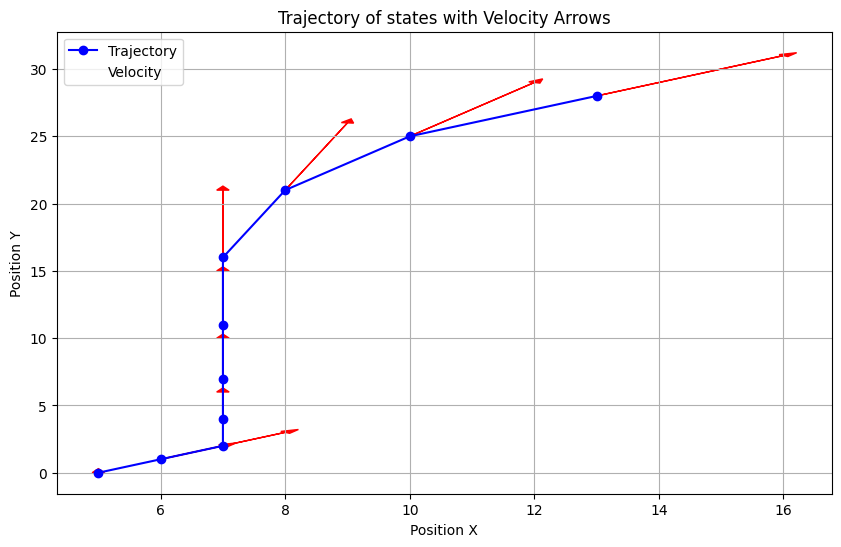

In [209]:
episode = racetrack3.run_episode_pi()
print(episode)

px = [state[1] for state, _, _ in episode]
py = [state[0] for state, _, _ in episode]
vx = [state[3] for state, _, _ in episode]
vy = [state[2] for state, _, _ in episode]

plt.figure(figsize=(10, 6))
plt.plot(px, py, marker='o', linestyle='-', color='b', label='Trajectory')

# Plot a dummy arrow with plt.quiver to use in the legend for velocity arrows
plt.quiver(px[0], py[0], vx[0], vy[0], color='r', scale=21, scale_units='inches', label='Velocity', width=0.005, headwidth=3, headlength=4.5, alpha=0)

# Plot the actual velocity arrows with plt.arrow
for i in range(len(px)):
    plt.arrow(px[i], py[i], vx[i], vy[i], head_width=0.2, head_length=0.3, fc='r', ec='r')

plt.title('Trajectory of states with Velocity Arrows')
plt.xlabel('Position X')
plt.ylabel('Position Y')
plt.grid(True)
plt.legend()
plt.show()